# Project - Predicting if a customer would subscribe a term deposit

## Importing necessary libraries 

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
import seaborn as sns


## Loading and Processing Data

In [3]:
df_bank = pd.read_csv('bank-additional-full.csv',sep=';')

### Renaming the Columns

In [4]:
df_bank.columns

df_bank= df_bank.rename(columns={'default':'c_default', 'housing':'h_loan','loan':"p_loan",'contact':'cont_type','month':'lc_month','day_of_week':'lc_day'
               ,'duration':'lc_duration','campaign':'no_of_contact',"pdays":'no_of_day_after_lc','previous':'no_of_contact_prev','emp.var.rate':'emp_var_rate','cons.price.idx':'cons_price_index','cons.conf.idx':'cons_conf_idx','euribor3m':'i_euribor3','nr.employed':'no_employee'})

In [5]:
len(df_bank.columns) #20 Features, 1 Target variable

21

### Deleting Columns

In [6]:
df_bank.drop(['lc_duration'],axis=1,inplace=True)       #Dropping lc_duration column since, y  is automatically known when duration is known (after the call)

In [7]:
df_bank.drop(['c_default'], axis =1, inplace= True) #Dropping c_default column, since there are just 3 records that has credit default 
                                                        #Doesn't add extra information 

In [8]:
len(df_bank.columns)

19

In [9]:
df_bank['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

### Replacing 'unknown' values with mode of the corresponding column

In [10]:
### Replacing 'unknown' values with mode of the corresponding columndf_bank['education'] = [df_bank['education'].mode()[0] if x== 'unknown' else x for x in df_bank['education']]
df_bank['job'] = df_bank['job'].map(lambda x: df_bank['job'].mode()[0] if x == 'unknown' else x)
df_bank['h_loan'] = df_bank['h_loan'].map(lambda x: df_bank['h_loan'].mode()[0] if x == 'unknown' else x)
df_bank['p_loan'] = df_bank['p_loan'].map(lambda x: df_bank['p_loan'].mode()[0] if x == 'unknown' else x)
df_bank['education'] = df_bank['education'].map(lambda x: df_bank['education'].mode()[0] if x == 'unknown' else x)

### Label encoding of ordinal education values

In [11]:
education = []
for value in df_bank['education']:
    if value == 'illiterate':
        education.append('1')
    elif value == 'basic.4y':
        education.append('2')         
    elif value == 'basic.6y':
        education.append('3')
    elif value == 'basic.9y':
        education.append('4')
    elif value == 'high.school':
        education.append('5')
    elif value == 'professional.course':
        education.append('6')
    elif value == 'university.degree':
        education.append('7')
df_bank['education'] = education

In [12]:
df_bank

,age,job,marital,education,h_loan,p_loan,cont_type,lc_month,lc_day,no_of_contact,no_of_day_after_lc,no_of_contact_prev,poutcome,emp_var_rate,cons_price_index,cons_conf_idx,i_euribor3,no_employee,y
0,56,housemaid,married,2,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,5,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,5,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,3,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,5,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,6,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,6,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,7,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,6,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### Dropping duplicates

In [13]:
df_bank.drop_duplicates(inplace=True) 

In [14]:
df_bank

,age,job,marital,education,h_loan,p_loan,cont_type,lc_month,lc_day,no_of_contact,no_of_day_after_lc,no_of_contact_prev,poutcome,emp_var_rate,cons_price_index,cons_conf_idx,i_euribor3,no_employee,y
0,56,housemaid,married,2,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,5,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,5,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,3,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,5,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,6,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,6,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,7,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,6,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### Changing data type of education column

In [15]:
df_bank['education'] = df_bank['education'].astype('int')

### Converting Target Variable to Binary Values

In [16]:
df_bank.index = range(len(df_bank))

In [17]:
df_bank['y'] = [int(1) if x == 'yes' else int(0) for x in df_bank['y']]

In [18]:
df_bank['y'].value_counts()

0    34486
1     4595
Name: y, dtype: int64

### Saving Client Data to use in Visualization 

In [19]:
df_bank_client = df_bank.iloc[:,:6]
df_bank_client.to_csv('client_data.csv')

In [20]:
df_bank_client

,age,job,marital,education,h_loan,p_loan
0,56,housemaid,married,2,no,no
1,57,services,married,5,no,no
2,37,services,married,5,yes,no
3,40,admin.,married,3,no,no
4,56,services,married,5,no,yes
...,...,...,...,...,...,...
39076,73,retired,married,6,yes,no
39077,46,blue-collar,married,6,no,no
39078,56,retired,married,7,yes,no
39079,44,technician,married,6,no,no


### Separating numerical and categorical data 

In [21]:
df_bank_cat = df_bank.select_dtypes(exclude=np.number)

In [22]:
df_bank_cat

,job,marital,h_loan,p_loan,cont_type,lc_month,lc_day,poutcome
0,housemaid,married,no,no,telephone,may,mon,nonexistent
1,services,married,no,no,telephone,may,mon,nonexistent
2,services,married,yes,no,telephone,may,mon,nonexistent
3,admin.,married,no,no,telephone,may,mon,nonexistent
4,services,married,no,yes,telephone,may,mon,nonexistent
...,...,...,...,...,...,...,...,...
39076,retired,married,yes,no,cellular,nov,fri,nonexistent
39077,blue-collar,married,no,no,cellular,nov,fri,nonexistent
39078,retired,married,yes,no,cellular,nov,fri,nonexistent
39079,technician,married,no,no,cellular,nov,fri,nonexistent


### One-Hot Encoding 

In [23]:
df_bank_cat_encoded=pd.get_dummies(df_bank_cat, drop_first=True)

In [24]:
df_bank_cat_encoded

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,lc_month_may,lc_month_nov,lc_month_oct,lc_month_sep,lc_day_mon,lc_day_thu,lc_day_tue,lc_day_wed,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39076,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
39077,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
39078,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
39079,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


### Concatenating numerical and encoded dataframes 

In [25]:
data_transformed = pd.concat([df_bank_cat_encoded, df_bank.select_dtypes(include=np.number)], axis=1)

In [26]:
data_transformed['y'].value_counts() # There is an imbalance in target feature

0    34486
1     4595
Name: y, dtype: int64

### Handling imbalanced Data using SMOTE

In [27]:
smote = SMOTE()

y = data_transformed['y']
X = data_transformed.drop(['y'], axis = 1)

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

0    34486
1    34486
Name: y, dtype: int64

In [47]:
data_transformed['y'].value_counts()

0    34486
1     4595
Name: y, dtype: int64

In [49]:
y_sm    #68972 Data Points after Upsampling

0        0
1        0
2        0
3        0
4        0
        ..
68967    1
68968    1
68969    1
68970    1
68971    1
Name: y, Length: 68972, dtype: int64

## EDA

In [59]:
df_bank

,age,job,marital,education,h_loan,p_loan,cont_type,lc_month,lc_day,no_of_contact,no_of_day_after_lc,no_of_contact_prev,poutcome,emp_var_rate,cons_price_index,cons_conf_idx,i_euribor3,no_employee,y
0,56,housemaid,married,2,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,5,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,5,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,3,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,5,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39076,73,retired,married,6,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
39077,46,blue-collar,married,6,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
39078,56,retired,married,7,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
39079,44,technician,married,6,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


In [83]:
df_bank['age'].value_counts()

31    1809
32    1746
33    1720
35    1659
36    1653
      ... 
89       2
91       2
94       1
87       1
95       1
Name: age, Length: 78, dtype: int64

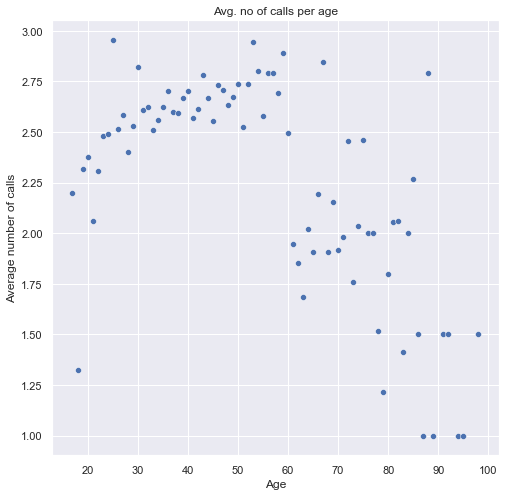

In [187]:



age_freq = df_bank['age'].value_counts()

no_of_tot_cont_per_age = df_bank.groupby(['age'])['no_of_contact'].sum()

no_of_cont_per_age = dict()



for age in age_freq.index:
    freq = age_freq[age]
    tot_con = no_of_tot_cont_per_age[age]
    no_of_cont_per_age[age] = tot_con/freq
    
contact_per_age = no_of_cont_per_age.items()
contact_per_age = sorted(contact_per_age)
x, y = zip(*contact_per_age)


sns.scatterplot(x=x,y=y)
plt.title('Avg. no of calls per age')
plt.xlabel("Age")
plt.ylabel("Average number of calls")
sns.set(rc = {'figure.figsize':(8,8)})

In [203]:
positive_response = df_bank[df_bank['y']==1]

pos = positive_response['age'].value_counts()

all_p = df_bank['age'].value_counts()
ratio_of_positive = dict()
for age in pos.index:
    ratio_of_positive[age]= pos[age]/all_p[age]
    



In [241]:
ages = list(ratio_of_positive.keys())


ratio = list(ratio_of_positive.values())

bins = [0,10,20,30,40,50,60,70,80,90,100]

data_tuples = list(zip(ages,ratio))

df_ratio = pd.DataFrame(data_tuples,columns=['ages','ratio'])

df_ratio['bin'] = pd.cut(df_ratio['ages'],bins=range(0,101,10), labels=[f'{l}-{l+10}' for l in range(0,91,10)])



<AxesSubplot:xlabel='bin'>

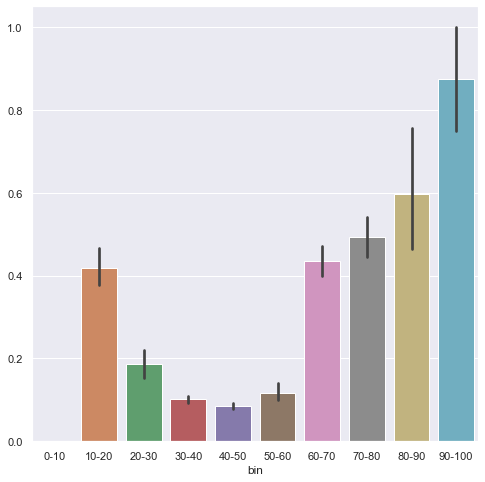

In [259]:
sns.barplot(x=df_ratio['bin'],y=ratio)


## Model Comparison

In [245]:
model1 = DecisionTreeClassifier()

model2 = LogisticRegression()

model3 = KNeighborsClassifier()

model_pipeline = [model1, model2, model3]
model_names = ['Decision Tree', 'Logistic Regression', 'KNN']
scores = {}
i=0
for model in model_pipeline:
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))
    scores[model_names[i]] = mean_score
    i = i+1
print(scores)

C:\Users\aykut\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aykut\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'Decision Tree': 0.8776926263463132, 'Logistic Regression': 0.7888152444076223, 'KNN': 0.8346520298260149}


## Choosing the best Decision Tree depth using cross-validation 

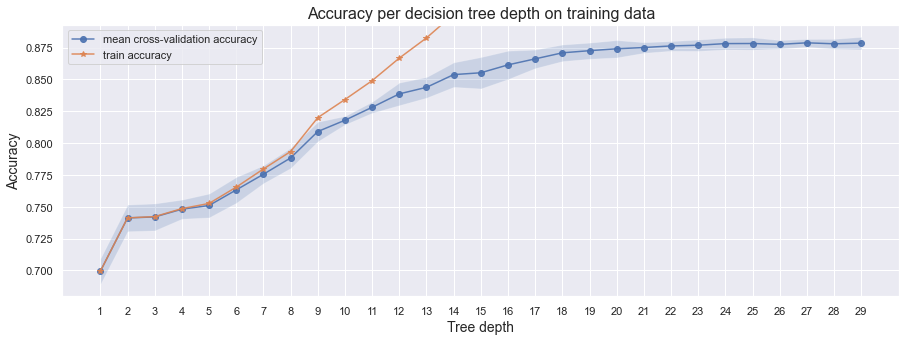

In [246]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=11)

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,30)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [247]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))


The depth-27 tree achieves the best mean cross-validation accuracy 87.86868 +/- 0.15243% on training dataset


Best accuracy obtained with a depth of 25. 

## Fitting Decision Tree Classifier

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=11)

model = DecisionTreeClassifier(max_depth=25)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

,Error_metric,Train,Test
0,Accuracy,0.992088,0.884883
1,Precision,0.992763,0.867729
2,Recall,0.991451,0.906250


## Fitting Logistic Regression

In [249]:
model1 = LogisticRegression() 

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=11)

std_scaler=StandardScaler().fit(X_train)   ##. finding the parameters ( mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train)
X_test_scaled=std_scaler.transform(X_test)





model1.fit(X_train_scaled, y_train)

y_pred_train = model1.predict(X_train_scaled)
y_pred_test = model1.predict(X_test_scaled)

np.unique(y_pred_test, return_counts=True)

(array([0, 1], dtype=int64), array([10788,  9904], dtype=int64))

,Error_metric,Train,Test
0,Accuracy,0.841777,0.842645
1,Precision,0.856467,0.854200
2,Recall,0.822334,0.823598


Confusion matrix for the training set


C:\Users\aykut\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


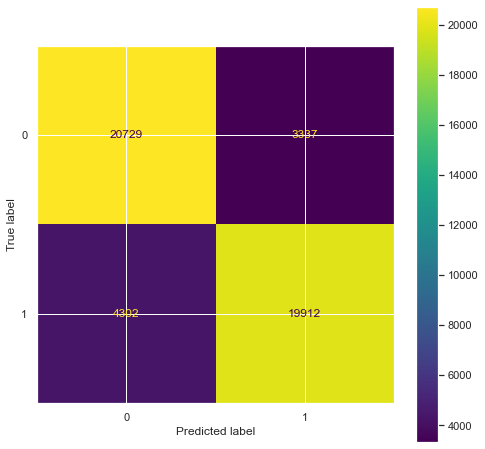

In [250]:
performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

print("Confusion matrix for the training set")



plot_confusion_matrix(model1,X_train_scaled,y_train, values_format='d')
plt.show()

## KNN Classification

In [251]:
X_train, X_test, y_train, y_test=train_test_split(X_sm, y_sm, test_size=.20,random_state=123)

In [252]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2,weights='uniform')
model.fit(X_train, y_train)
y_pred_test=model.predict(X_test)
y_pred_train=model.predict(X_train)

In [253]:
performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

,Error_metric,Train,Test
0,Accuracy,0.973993,0.890758
1,Precision,0.998666,0.875681
2,Recall,0.949275,0.910398


## Random Forest Hyper Parameter Tuning 

In [254]:
X_train, X_test, y_train, y_test=train_test_split(X_sm, y_sm, test_size=.20,random_state=123)

param_grid = {
    'n_estimators': [50, 100,500],
    'min_samples_split': [2, 4],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt']
    ##'max_samples' : ['None', 0.5],
    ##'max_depth':[3,5,10],
    ## 'bootstrap':[True,False] 
    }
clf = RandomForestClassifier(random_state=100)

grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

grid_search.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [ ]:
clf = RandomForestClassifier(random_state=0, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=500)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

In [ ]:
clf.fit(X_train, y_train)
y_pred_test=clf.predict(X_test)
y_pred_train=clf.predict(X_train)

In [ ]:
performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

In [ ]:
with open("clf.pickle", "wb") as file:
    pickle.dump(clf, file)

In [ ]:
with open("clf.pickle", "rb") as file:
    model = pickle.load(open("clf.pickle", "rb"))

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

### Feature Importance

In [ ]:
feature_names = X_train.columns
feature_names = list(feature_names)

df = pd.DataFrame(list(zip(feature_names, clf.feature_importances_)))
df.columns = ['columns_name', 'score_feature_importance']
df.sort_values(by=['score_feature_importance'], ascending = False)



## Feature Selection

### Recursive Feature Elimination

In [ ]:

model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=11)


selector = RFE(model, n_features_to_select= 33, step = 1, verbose = 1) # Step is how many features to add or drop everytime
selector.fit(X_train, y_train)



kept_features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train.iloc[:,kept_features].columns)

X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

X_train = pd.DataFrame(X_train, columns=kept_features)
X_test  = pd.DataFrame(X_test, columns=kept_features)

print("Final selected features: ")
display(X_train)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.30, random_state=11)

std_scaler=StandardScaler().fit(X_train)   ##. finding the parameters ( mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train)
X_test_scaled=std_scaler.transform(X_test)





clf.fit(X_train_scaled, y_train)

y_pred_train = clf.predict(X_train_scaled)
y_pred_test = clf.predict(X_test_scaled)

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

In [ ]:
print("Confusion matrix for the training set")



plot_confusion_matrix(model2,X_train_scaled,y_train, values_format='d')
plt.show()

In [ ]:
performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

### Upsampling(Manual)

In [ ]:
data = data_transformed

In [ ]:
data

In [ ]:
category_0 = data[data['y'] == 0]
category_1 = data[data['y'] == 1]

len(category_0), len(category_1)

category_1_up = category_1.sample(len(category_0), replace=True)

category_1_up.shape, category_0.shape

data = pd.concat([category_0,category_1_up],axis = 0)
data = data.sample(frac=1)

data['y'].value_counts()



In [ ]:
X = data.drop(columns=['y'],axis=1)
y = data['y']
model1 = LogisticRegression()
model2 = DecisionTreeClassifier(max_depth=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11)


selector = RFE(model2, n_features_to_select= 35, step = 1, verbose = 1) # Step is how many features to add or drop everytime
selector.fit(X_train, y_train)



kept_features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train.iloc[:,kept_features].columns)

X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

X_train = pd.DataFrame(X_train, columns=kept_features)
X_test  = pd.DataFrame(X_test, columns=kept_features)

print("Final selected features: ")
display(X_train)

In [ ]:
std_scaler=StandardScaler().fit(X_train)   ##. finding the parameters ( mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train)
X_test_scaled=std_scaler.transform(X_test)





model2.fit(X_train_scaled, y_train)

y_pred_train = model2.predict(X_train_scaled)
y_pred_test = model2.predict(X_test_scaled)

In [ ]:
print("Confusion matrix for the training set")



plot_confusion_matrix(model2,X_train_scaled,y_train, values_format='d')
plt.show()

In [ ]:
performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

### Downsampling 

In [ ]:
data1 = data_transformed


category_0 = data1[data1['y'] == 0]
category_1 = data1[data1['y'] == 1]

len(category_0), len(category_1)

category_0_down = category_0.sample(len(category_1), replace=True)

category_1_up.shape, category_0.shape

data1 = pd.concat([category_0_down,category_1],axis = 0)
data1 = data1.sample(frac=1)

data1['y'].value_counts()

In [ ]:
# X = data1.drop(columns=['y'],axis=1)
# y = data1['y']
# model1 = LogisticRegression()
model2 = DecisionTreeClassifier(max_depth=10)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11)


selector = RFE(model2, n_features_to_select= 38, step = 1, verbose = 1) # Step is how many features to add or drop everytime
selector.fit(X_train, y_train)



kept_features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train.iloc[:,kept_features].columns)

X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

X_train = pd.DataFrame(X_train, columns=kept_features)
X_test  = pd.DataFrame(X_test, columns=kept_features)

print("Final selected features: ")
display(X_train)

In [ ]:
kept_features

In [ ]:
std_scaler=StandardScaler().fit(X_train)   ##. finding the parameters ( mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train)
X_test_scaled=std_scaler.transform(X_test)





model2.fit(X_train_scaled, y_train)

y_pred_train = model2.predict(X_train_scaled)
y_pred_test = model2.predict(X_test_scaled)

In [ ]:
print("Confusion matrix for the training set")



plot_confusion_matrix(model2,X_train_scaled,y_train, values_format='d')
plt.show()


performance = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance)

- age (numeric)- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

## Decision Tree Classifier